**IMPORTING THE LIBRARIES**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

**DATA PREPROCESSING**



In [ ]:
_URL='https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip=tf.keras.utils.get_file('cats_and_dogs.zip',origin=_URL,extract=True)
PATH=os.path.join(os.path.dirname(path_to_zip),'cats_and_dogs_filtered')



68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
train_dir=os.path.join(PATH,'train')
valid_dir=os.path.join(PATH,'validation')

In [ ]:
BATCH_SIZE=32
IMG_SIZE=(160,160)



In [ ]:
train_dataset=tf.keras.utils.image_dataset_from_directory(train_dir,
                                                          shuffle=True,
                                                          batch_size=BATCH_SIZE,
                                                          image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset=tf.keras.utils.image_dataset_from_directory(valid_dir,
                                                               shuffle=True,
                                                               batch_size=BATCH_SIZE,
                                                               image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


In [ ]:
class_names=train_dataset.class_names


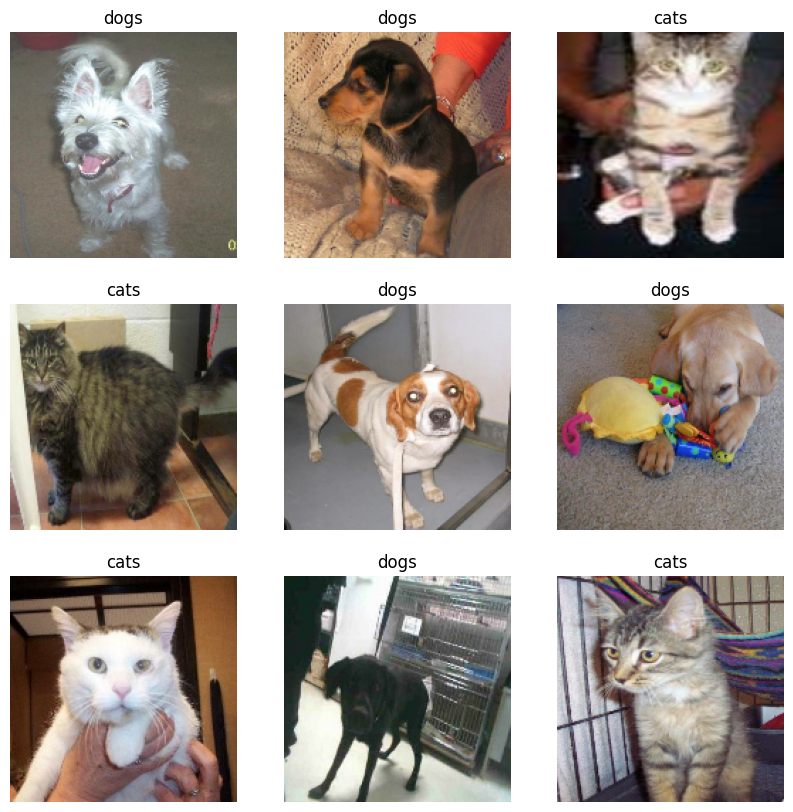

In [ ]:
plt.figure(figsize=(10,10))
for images,labels in train_dataset.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

**SPLITTING VALIDATION**

In [ ]:
val_batches=tf.data.experimental.cardinality(validation_dataset)
test_dataset=validation_dataset.take(val_batches//5)
validation_dataset=validation_dataset.skip(val_batches//5)

In [ ]:
print(f"the total no of validation batches are {tf.data.experimental.cardinality(validation_dataset)}")
print(f"the total no of test batches are {tf.data.experimental.cardinality(test_dataset)}")

the total no of validation batches are 26
the total no of test batches are 6


In [ ]:
AUTOTUNE=tf.data.AUTOTUNE
train_dataset=train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset=validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset=test_dataset.prefetch(buffer_size=AUTOTUNE)

**DATA AUGUMENTATION**

In [ ]:
data_augumentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizantal'),
    tf.keras.layers.RandomRotation(0.2)
])

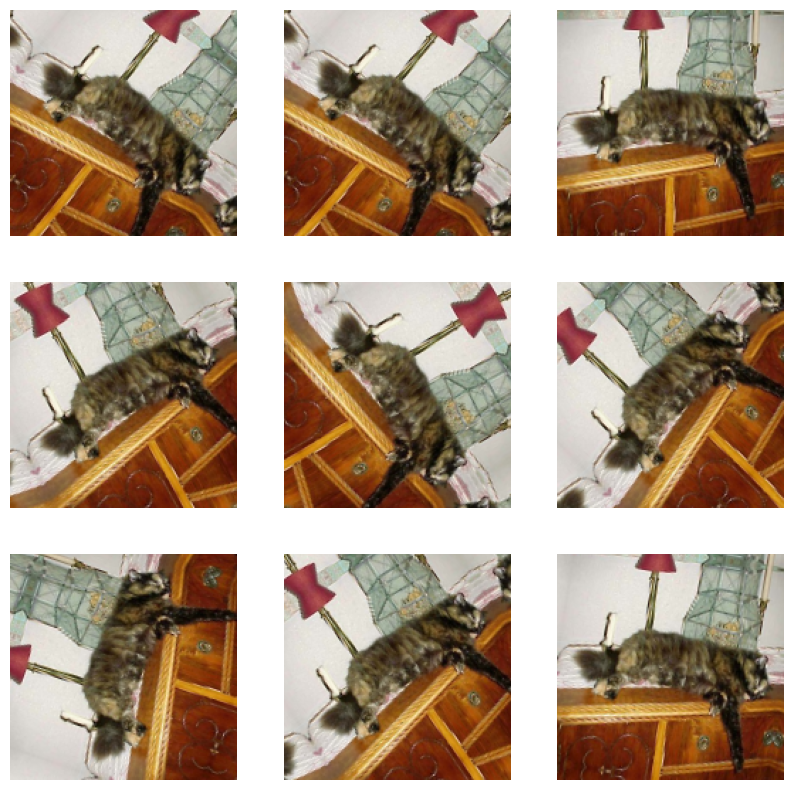

In [ ]:
for image,_ in train_dataset.take(1):
  plt.figure(figsize=(10,10))
  first_image=image[0]
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    augumented_image=data_augumentation(tf.expand_dims(first_image,0))
    plt.imshow(augumented_image[0]/255)
    plt.axis("off")


**RESCALING PIXEL VALUES**

In [ ]:
preprocess_input=tf.keras.applications.mobilenet_v2.preprocess_input

**CREATING THE BASE MODEL FROM THE PRETRAINED CONVNETS**



In [ ]:
IMG_SHAPE=IMG_SIZE+(3,)
base_model=tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
image_batch,label_batch=next(iter(train_dataset))
feature_batch=base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


**FEATURE EXTRACTION**

**FREEZE THE CONVOLUTION BASE**

In [ ]:
base_model.trainable=False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 160, 160, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 80, 80, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 80, 80, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 80, 80, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 80, 80, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 80, 80, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 80, 80, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 80, 80, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 80, 80, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 80, 80, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 81, 81, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 40, 40, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

**ADD A CLASSIFICATION HEAD**

In [ ]:
global_average_layer=tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average=global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer=tf.keras.layers.Dense(1,activation='sigmoid')
prediction_batch=prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs=tf.keras.Input(shape=(160,160,3))
x=data_augumentation(inputs)
x=preprocess_input(x)
x=base_model(x,training=False)
x=global_average_layer(x)
x=tf.keras.layers.Dropout(0.2)(x)
outputs=prediction_layer(x)
model=tf.keras.Model(inputs,outputs)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
len(model.trainable_variables)

2

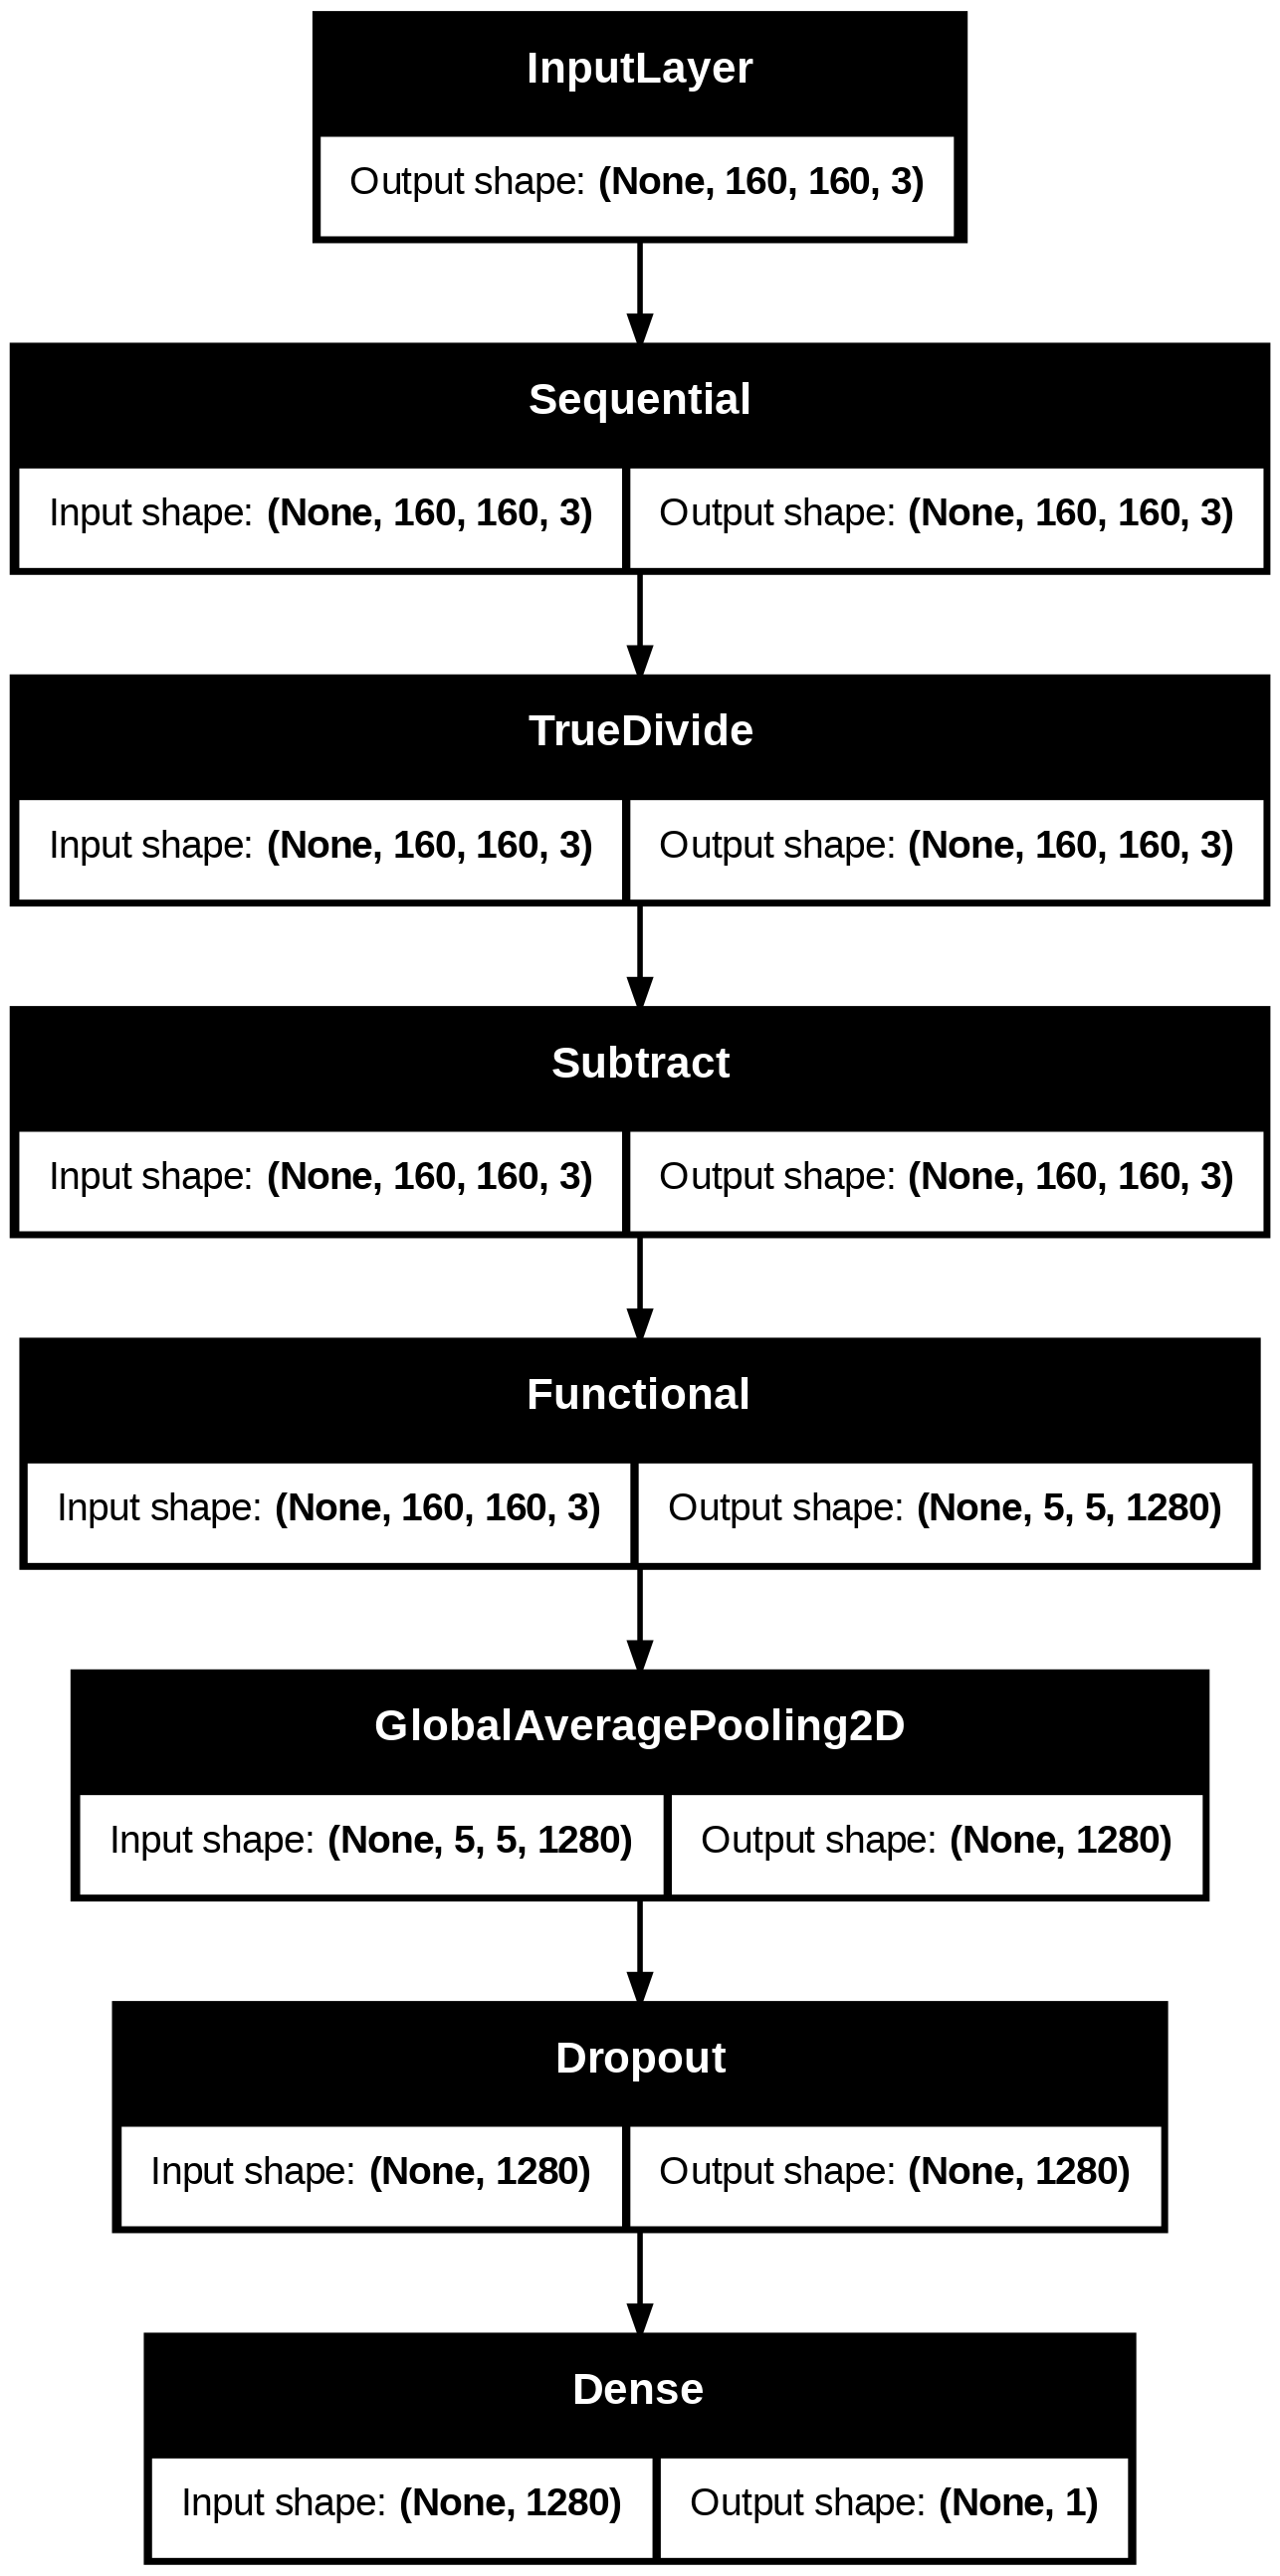

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True)

**COMPILE THE MODEL**

In [ ]:
base_learning_rate=0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5,name='accuracy')])

**TRAIN THE MODEL**

In [ ]:
initial_epochs=10
loss0,accuracy0=model.evaluate(validation_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 619ms/step - accuracy: 0.5449 - loss: 0.7407


In [ ]:
print("Initial loss:{:.2f}".format(loss0))
print("Initial accuracy:{:.2f}".format(accuracy0))

Initial loss:0.78
Initial accuracy:0.50


In [ ]:
history=model.fit(train_dataset,
                  epochs=initial_epochs,
                  validation_data=validation_dataset)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.5442 - loss: 0.7988 - val_accuracy: 0.7389 - val_loss: 0.5481
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 78s 964ms/step - accuracy: 0.7366 - loss: 0.5569 - val_accuracy: 0.8899 - val_loss: 0.3928
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 920ms/step - accuracy: 0.8037 - loss: 0.4403 - val_accuracy: 0.9332 - val_loss: 0.3011
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 929ms/step - accuracy: 0.8582 - loss: 0.3687 - val_accuracy: 0.9517 - val_loss: 0.2419
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.8687 - loss: 0.3224 - val_accuracy: 0.9567 - val_loss: 0.2078
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 75s 939ms/step - accuracy: 0.8909 - loss: 0.2953 - val_accuracy: 0.9604 - val_loss: 0.1825
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 85s 987ms/step - accuracy: 0.8975 - loss: 0.2585 - val_accuracy: 0.9629 - val_loss: 0.1668
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 80s 960ms/step - accuracy: 0.9194 - loss: 0.2250 - val_accuracy: 

**LEARNING THE CURVES**

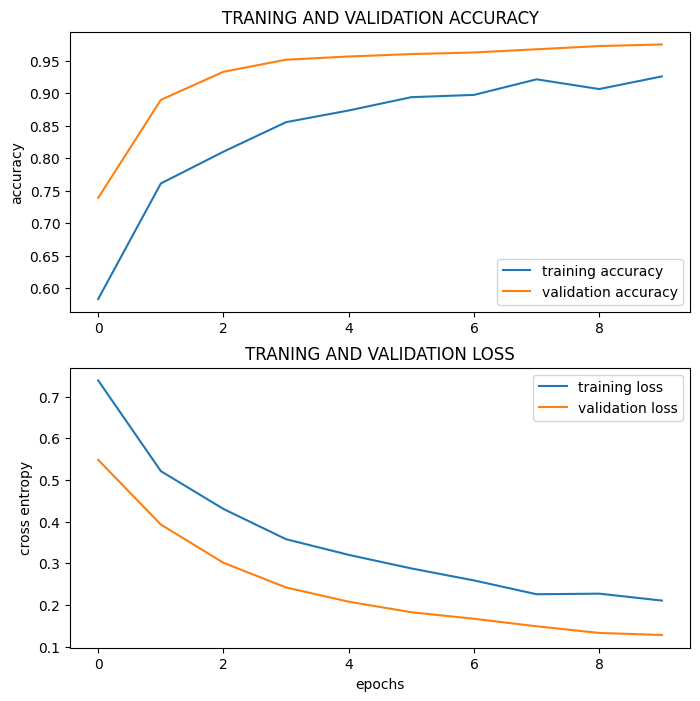

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']


plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc,label='training accuracy')
plt.plot(val_acc,label='validation accuracy')
plt.legend(loc='lower right')
plt.ylabel('accuracy')
plt.title("TRANING AND VALIDATION ACCURACY")


plt.subplot(2,1,2)
plt.plot(loss,label='training loss')
plt.plot(val_loss,label='validation loss')
plt.legend(loc='upper right')
plt.ylabel('cross entropy')
plt.title("TRANING AND VALIDATION LOSS")
plt.xlabel("epochs")
plt.show()


**FINE TUNING**

In [ ]:
base_model.trainable=True

**UNFREEZE THE TOP LAYERS OF THE MODEL**

In [ ]:
print(f"THE NUMBER OF LAYERS IN THE BASE MODEL OF MOBILENET ARE {len(base_model.layers)}")
fine_tune_at=100
for layers in base_model.layers[:fine_tune_at]:
  layers.trainable=False

THE NUMBER OF LAYERS IN THE BASE MODEL OF MOBILENET ARE 154


**COMPILE THE MODEL**

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5,name='accuracy')])

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [ ]:
len(model.trainable_variables)

56

**CONTINUES TRAINING THE MODEL**

In [ ]:
fine_tune_epochs=10
total_epochs=initial_epochs+fine_tune_epochs
history_fine=model.fit(train_dataset,
                       epochs=total_epochs,
                       initial_epoch=len(history.epoch),
                       validation_data=validation_dataset)

Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.7985 - loss: 0.4318 - val_accuracy: 0.9765 - val_loss: 0.0929
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.8771 - loss: 0.2873 - val_accuracy: 0.9765 - val_loss: 0.0762
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9259 - loss: 0.2024 - val_accuracy: 0.9827 - val_loss: 0.0625
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.9185 - loss: 0.2057 - val_accuracy: 0.9790 - val_loss: 0.0605
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.9330 - loss: 0.1661 - val_accuracy: 0.9814 - val_loss: 0.0565
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.9392 - loss: 0.1613 - val_accuracy: 0.9802 - val_loss: 0.0527
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9404 - loss: 0.1447 - val_accuracy: 0.9851 - val_loss: 0.0471
Epoch 18/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9561 - loss: 0.1229 - val_accuracy: 0.9

In [ ]:
acc+=history_fine.history['accuracy']
val_acc+=history_fine.history['val_accuracy']

loss+=history_fine.history['loss']
val_loss+=history_fine.history['val_loss']



Text(0.5, 1.0, 'TRAINING AND VALIDATION LOSS')

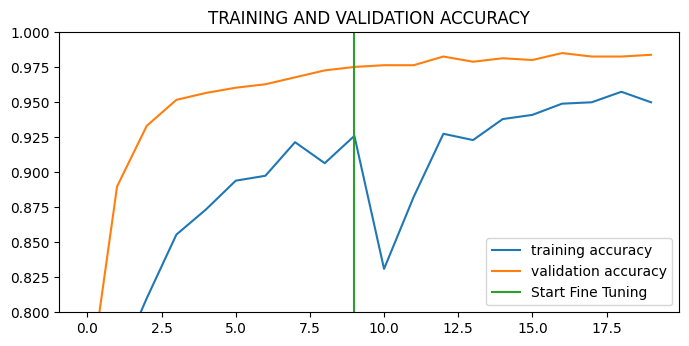

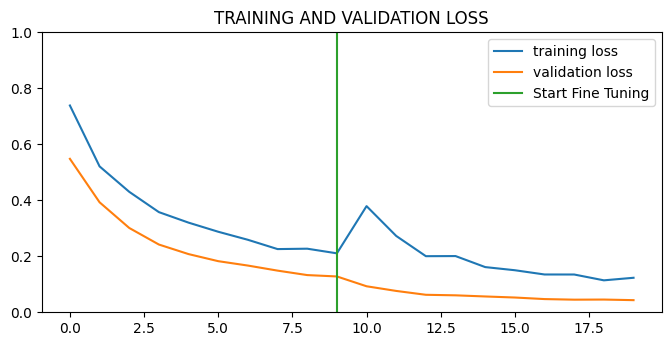

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc,label='training accuracy')
plt.plot(val_acc,label='validation accuracy')
plt.ylim([0.8,1])
plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title("TRAINING AND VALIDATION ACCURACY")


plt.figure(figsize=(8,8))
plt.subplot(2,1,2)
plt.plot(loss,label='training loss')
plt.plot(val_loss,label='validation loss')
plt.ylim([0,1.0])
plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title("TRAINING AND VALIDATION LOSS")

In [ ]:
loss ,accuracy=model.evaluate(test_dataset)
print(f"TEST ACCURACY:{accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 717ms/step - accuracy: 0.9904 - loss: 0.0258
TEST ACCURACY:0.9895833134651184


In [ ]:
image_batch,label_batch=test_dataset.as_numpy_iterator().next()
predictions=model.predict_on_batch(image_batch).flatten()
predictions=tf.where(predictions<0.5,0,1)

**EVALUATION AND PREDICTION**

In [ ]:
print(f"predictions:\n{predictions.numpy()}")
print(f"labels:\n{label_batch}")

predictions:
[0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 1 1 1 1 0 0 0 1 0 0 1 0]
labels:
[0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 1 1 1 1 0 0 0 1 0 0 1 0]


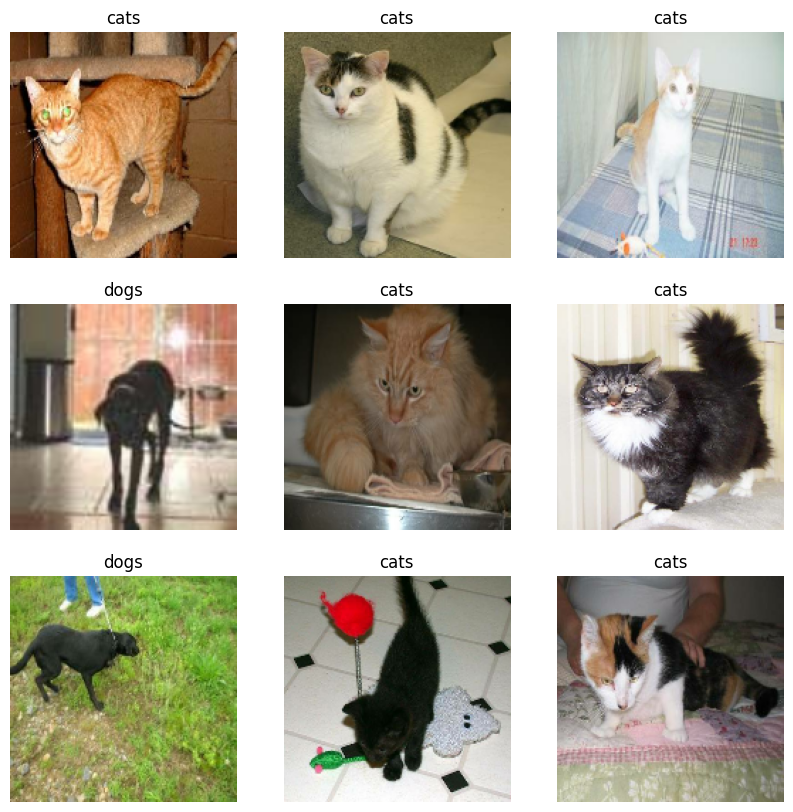

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
  ax=plt.subplot(3,3,i+1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")